In [1]:
# load base libraries
import skimage
import urllib3 as urllib
import numpy as np
from skimage import io, transform
import os
import cv2
import sys
import shutil
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import tensorflow as tf
from collections import defaultdict, Counter
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import json
import bi2i_cv

In [2]:
# load object detection libraries
sys.path.append('models/research/')
sys.path.append('models/research/slim/')


In [3]:
# input parameters
checkpoint = '60000'
model_path = 'data/'
graph_path = 'object_detection_graph_'+checkpoint
print('Graph path: {}'.format(graph_path))
filename =   'holdout'
iou_threshold = .3
conf_threshold = .3



Graph path: object_detection_graph_60000


In [4]:
# helpers
def class_text_to_int(row_label):
    if row_label == 'SC':
        return 1
    elif row_label == 'KS':
        return 2
    elif row_label == 'BT':
        return 3
    elif row_label == 'WB':
        return 4
    elif row_label == 'SD_SDCO':
        return 5
    elif row_label == 'TS':
        return 6
    elif row_label == 'SCS':
        return 7
    else:
        None

def class_int_to_text(row_label):
    if row_label == 1:
        return 'SC'
    elif row_label == 2:
        return 'KS'
    elif row_label == 3:
        return 'BT'
    elif row_label == 4:
        return 'WB'
    elif row_label == 5:
        return 'SD_SDCO'
    elif row_label == 6:
        return 'TS'
    elif row_label == 7:
        return 'SCS'
    else:
        None

def class_to_flags(clss):
    res = [0]*NUM_CLASSES
    for i in np.unique(clss):
        #print i
        res[int(i-1)] = 1
    return(np.array(res))

def items_flag(classes, scores):
    clss = classes[scores>.5]
    clss = class_to_flags(clss)
    return(pd.DataFrame({'image' : [image_path.split('/')[-1]], 'Others' : [clss[0]]}))

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


In [6]:
# load saved model
from utils import label_map_util
from utils import visualization_utils as vis_util


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = graph_path+'/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = model_path+'label_map.pbtxt'
print(PATH_TO_LABELS)
NUM_CLASSES = 8
IMAGE_SIZE = (12, 12)

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



data/label_map.pbtxt


In [7]:
# scoring 


In [26]:
def get_detections(image, show = True, save_local = False):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            print("scoring {}".format(image_path))
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],\
            feed_dict={image_tensor: image_np_expanded})
            #item_flags_df = pd.concat([item_flags_df, items_flag(classes, scores)])
            res_ixs = scores >= conf_threshold
            result_dict = {'boxes': boxes[res_ixs],
                        'items': [class_int_to_text(x) for x in classes[res_ixs]],
                        'classes': classes[res_ixs],
                        'scores': scores[res_ixs],
                        'item_flags': class_to_flags(classes[res_ixs])}
            print(result_dict['scores'])
            n_detections = len(result_dict['scores'])
            if n_detections > 0:
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw = 60,
                    line_thickness=2,
                    min_score_thresh = iou_threshold)
                if show == True:
                    plt.figure(figsize=IMAGE_SIZE)
                    plt.imshow(image_np)
                if save_local == True:
                    skimage.io.imsave(image_path.split('/')[-1], image_np)
    return(n_detections, result_dict, image_np)



In [37]:
# score an image
image_path = 'images/holdout/Designs_Severance_Avalon_Severance Shores-Avalon(2502)Arch-City Submittal-06-12-2019_41.jpg'
image = Image.open(image_path)
# image = image.resize((500, 500))
n_detections, detections, output_image = get_detections(image, show = False)


scoring images/holdout/Designs_Severance_Avalon_Severance Shores-Avalon(2502)Arch-City Submittal-06-12-2019_41.jpg
[0.99998367]


In [38]:
print(n_detections)

1


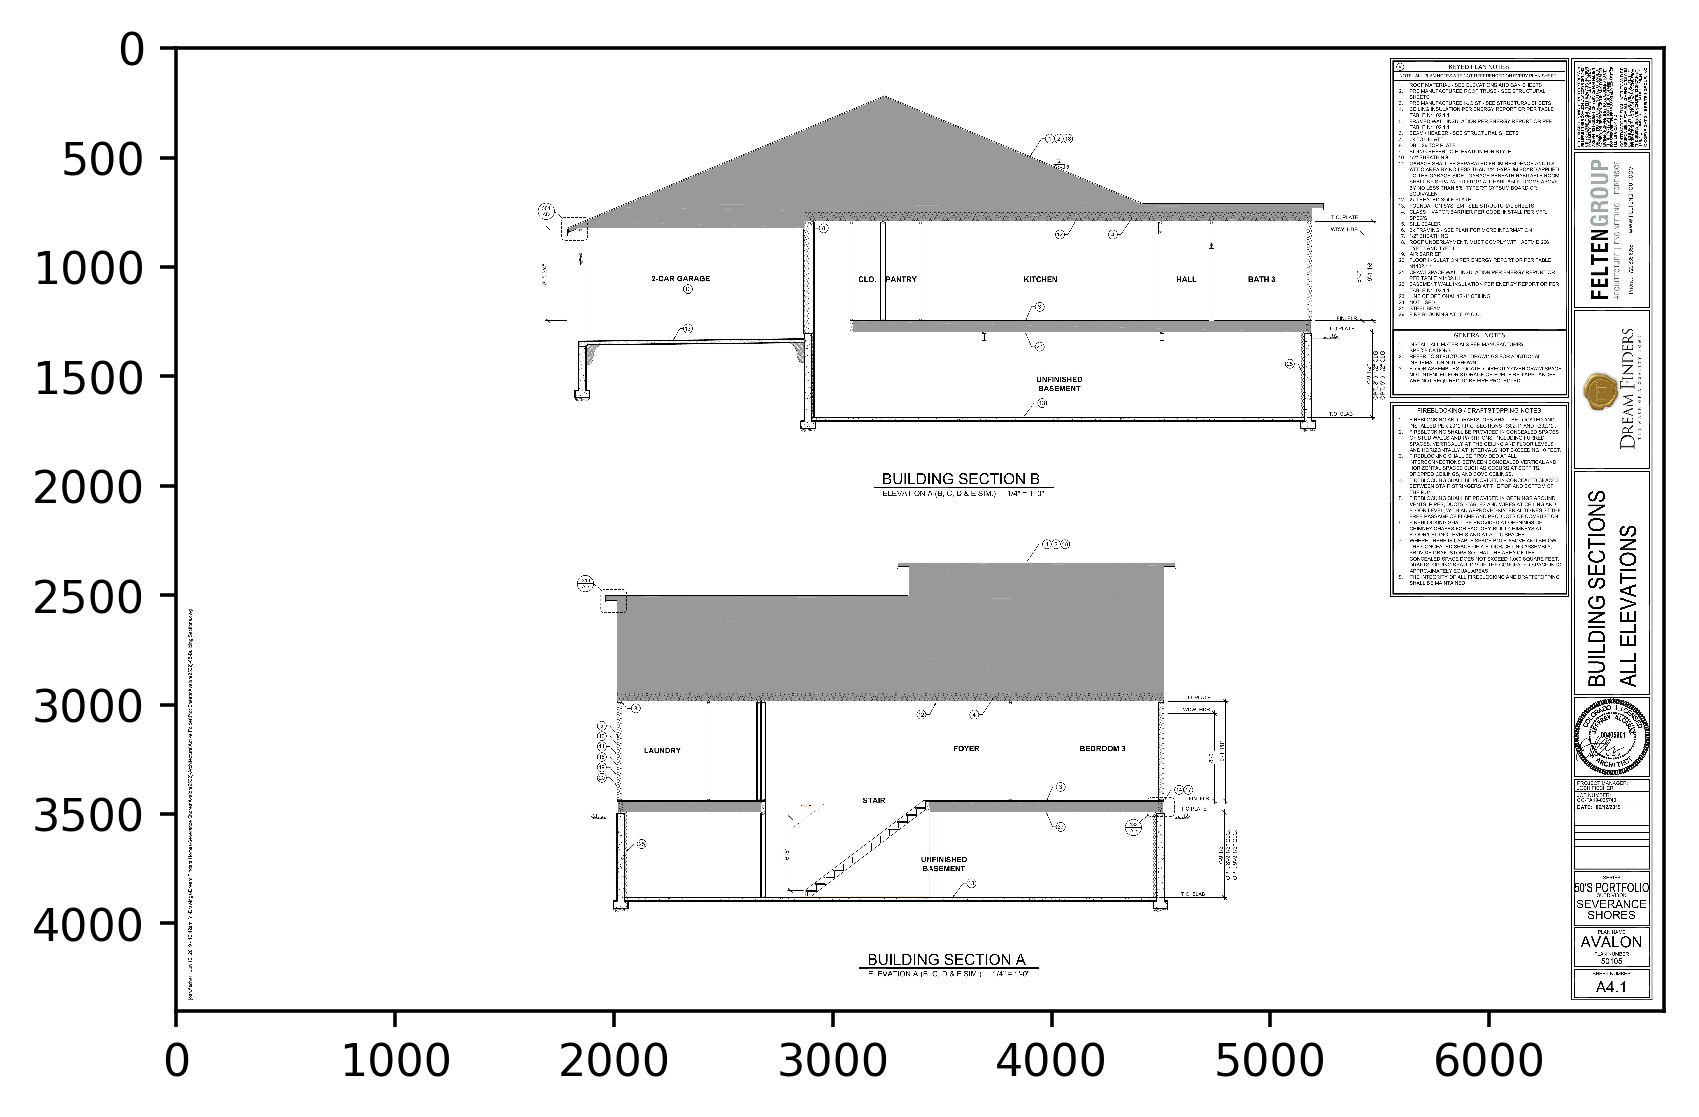

In [39]:
plt.figure(dpi = 320)
plt.imshow(output_image)

In [34]:
detections

{'boxes': array([[0.4529208 , 0.5019041 , 0.4776034 , 0.5176641 ],
        [0.46184194, 0.54200053, 0.48615766, 0.56260884],
        [0.4543475 , 0.52142406, 0.47513342, 0.53668743],
        [0.46559328, 0.5541728 , 0.49645165, 0.5721639 ]], dtype=float32),
 'classes': array([4., 6., 4., 3.], dtype=float32),
 'item_flags': array([0, 0, 1, 1, 0, 1, 0, 0]),
 'items': ['WB', 'TS', 'WB', 'BT'],
 'scores': array([0.99999666, 0.80421114, 0.6357803 , 0.462063  ], dtype=float32)}

In [35]:
cv2.imwrite('test_res.jpg', output_image)

True